In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 6.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = '/content/drive/MyDrive/hydrology_viotia/READY_FOR_EXPERIMENTS/dataset.csv'

In [ ]:
def scale(numpy_array):
  max = numpy_array.max(axis=0)
  scaled = numpy_array / max
  return scaled

In [ ]:
dataset = pd.read_csv(directory)
print(dataset.head())
print()
print(dataset.describe())
print('Dataset shape:', dataset.shape)

       aspect  soil_map_vathos          SPI  plan_curvature  soil_map_mitriko  \
0  181.798510                1  1470.215214       -5.891634                 8   
1  196.810470                1    12.509449        0.161344                 8   
2  217.899280                1    10.824725        0.238952                 8   
3   56.556160                1     0.078943      -12.565618                 8   
4   96.794495                7    46.228094       -0.019541                 4   

   lineaments_density_1000  lineaments_density_2000  profile_curvature  \
0                   857.44                   768.09           0.022728   
1                     0.00                   953.81          -1.073977   
2                   318.22                  1584.77          -1.315862   
3                  1395.39                  4343.02          -0.071508   
4                   896.27                  5682.44          -0.171140   

   convergence  DEM_basin_10m  ...     MRVBF  longitudinal_curvature

In [ ]:
#Merge and suffle data
data_np = dataset.values
data_np = shuffle(data_np, random_state = 100)
data_np = scale(data_np)

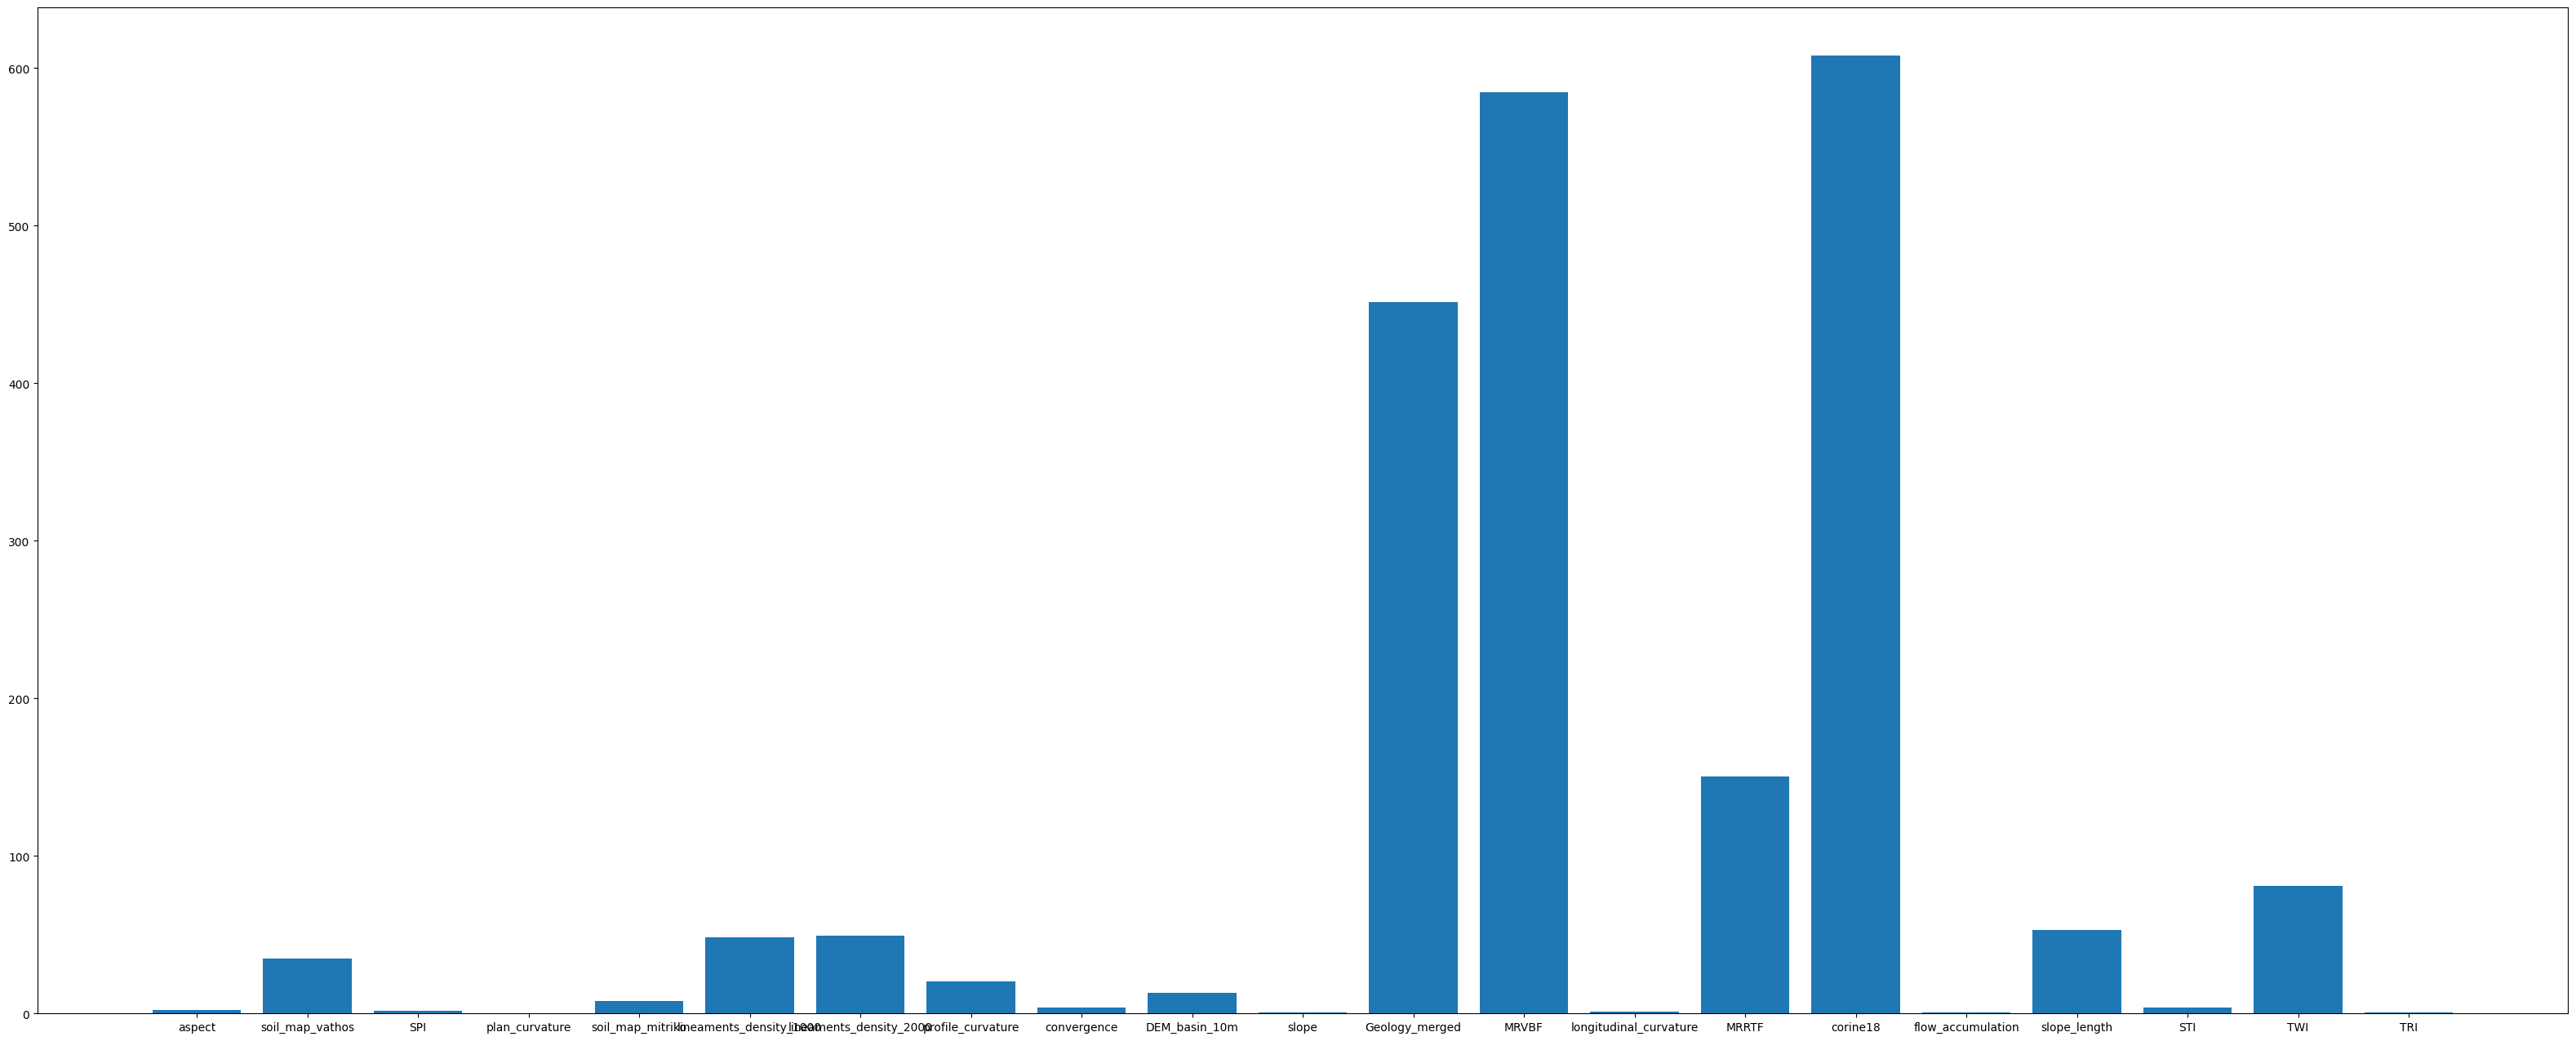

<Figure size 4000x1600 with 0 Axes>

In [ ]:
#Calculate feature importance
X = data_np[:, :-1]
y = data_np[:, -1]
kbest = SelectKBest(score_func=f_classif, k=10)
scores = kbest.fit(X, y)

var_names = dataset.columns
plt.rcParams["figure.figsize"] = (40,16)
plt.bar(var_names[:-1], scores.scores_)
plt.show()
plt.savefig("feature.png")

In [ ]:
#Selection of most important variables
var = [1, 5, 6, 11, 12, 14, 15, 17, 19, 21]
#data_extr = data_np[:, var]
print('Number of variables selected:', len(var))
print('Shape after feature extraction:', data_extr.shape)
print()

Number of variables selected: 10


NameError: ignored

In [ ]:
#Keep 10% of data for evaluation
X = data_np[:, :-1]
y = data_np[:, -1]
n_eval = (X.shape[0] * 10) // 100
X_train = X[n_eval:, :]
y_train = y[n_eval:]
X_eval = X[:n_eval, :]
y_eval = y[:n_eval]

In [ ]:
parameters = {'max_depth': [8, 12, 16, 20], 'n_estimators': [200, 240, 280, 320]}
clf = GridSearchCV(RandomForestClassifier(),
                   parameters,
                   scoring = 'accuracy')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")
print()

KeyboardInterrupt: ignored

The accuracy of the model is: 1.0



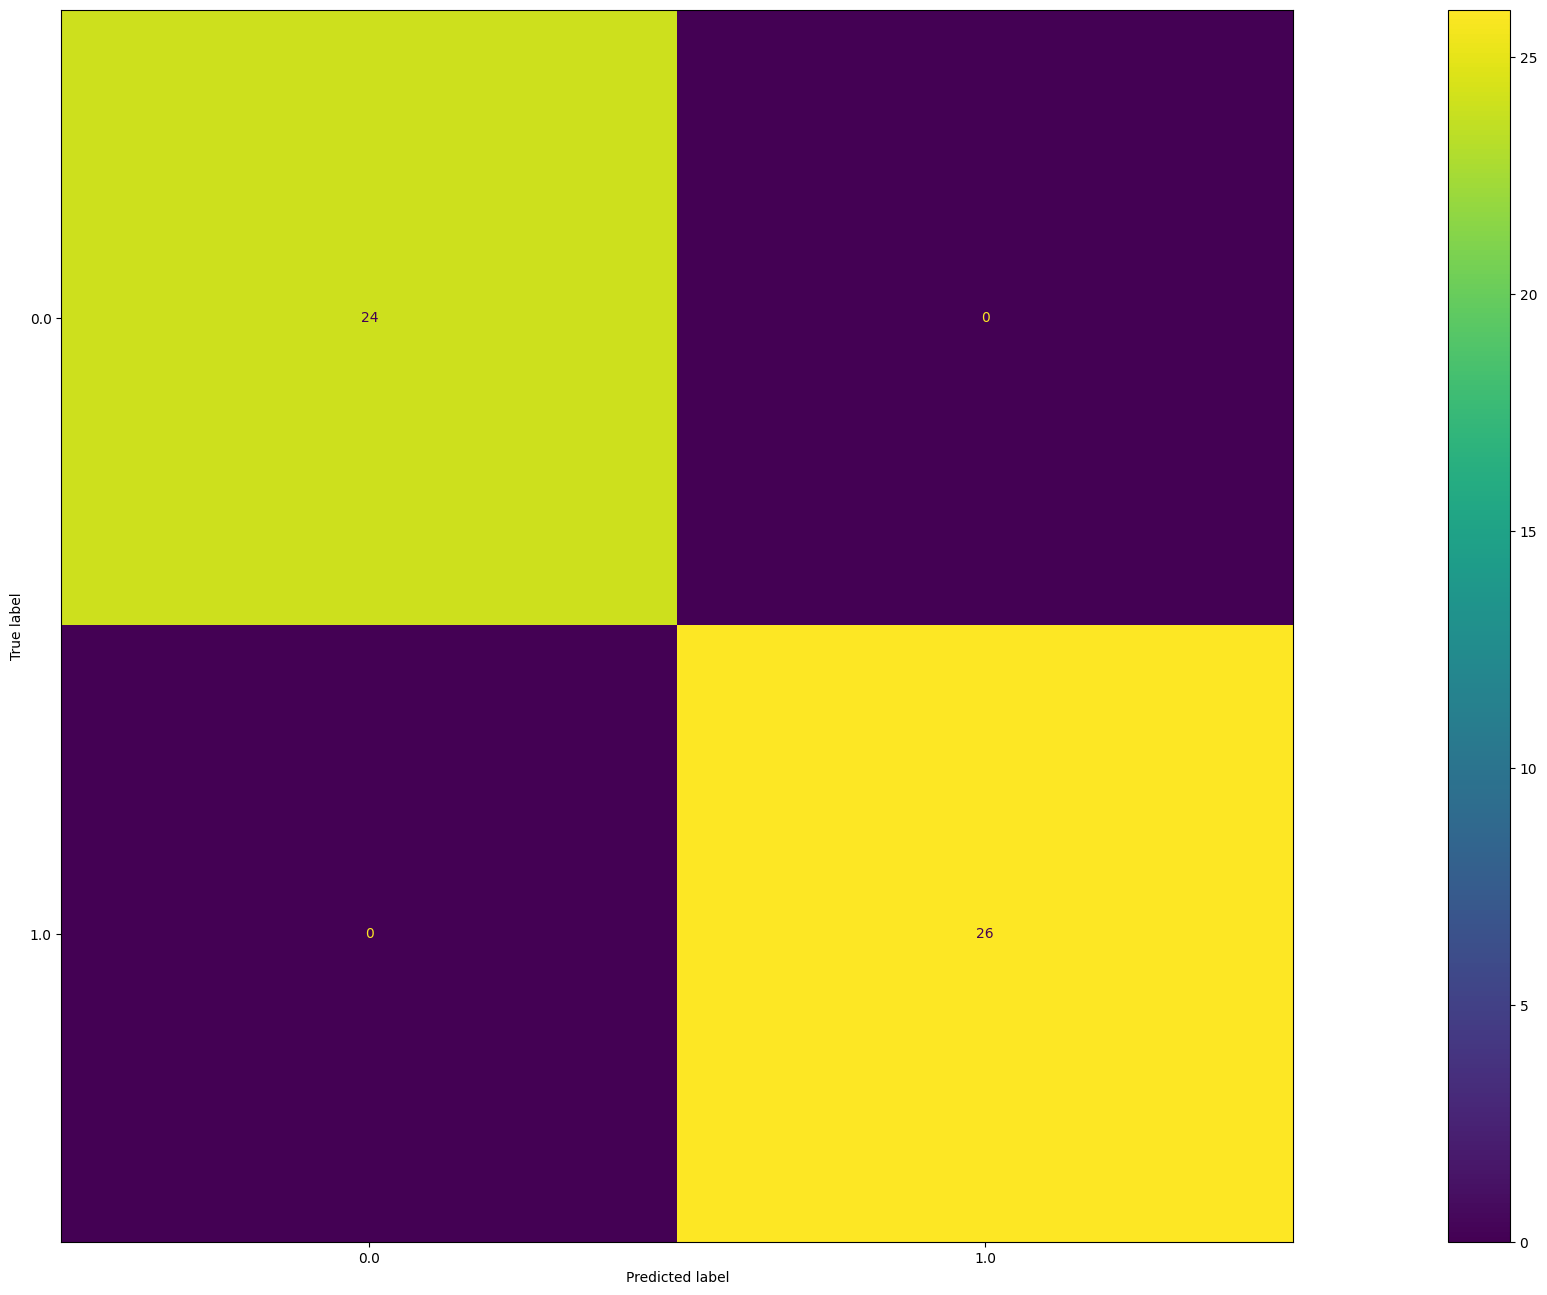

In [ ]:
#Accuracy
clf = RandomForestClassifier(max_depth = 8, n_estimators = 120)
clf.fit(X_train, y_train)
prediction = clf.predict(X_eval)
acc = metrics.accuracy_score(prediction, y_eval)
print('The accuracy of the model is:', acc)
print()

#Confusion matrix
cm = confusion_matrix(y_eval, prediction, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                               display_labels = clf.classes_)
disp.plot()

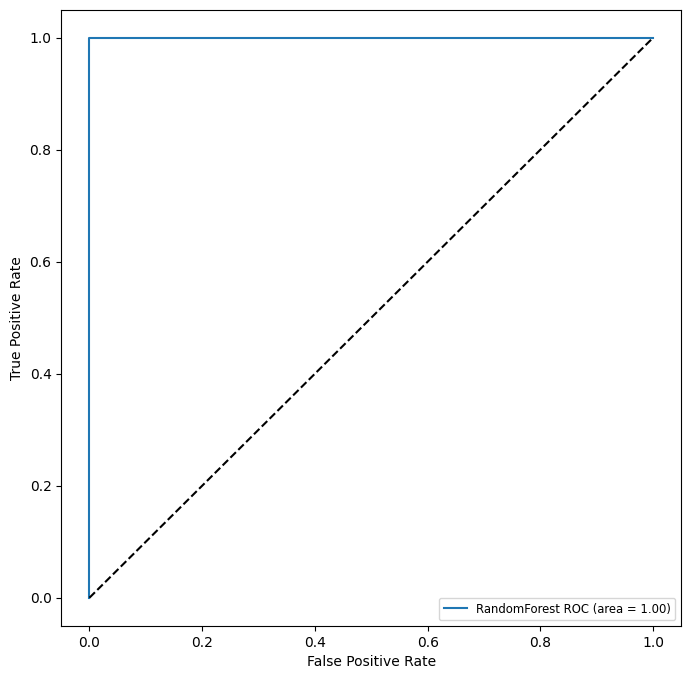

(50, 21)

In [ ]:
#Roc curve
clf.probability = True
probas = clf.predict_proba(X_eval) #predict probabilities: the predict_proba method returns the probabilities for each data point to belong in a class
fpr, tpr, thresholds = roc_curve(y_eval, probas[:, 1], pos_label =1)#assumes class 1 is the positive label
roc_auc  = auc(fpr, tpr)
 
fig2 = plt.figure(1,figsize=(8,8))
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("RandomForest", roc_auc))
ax2.plot([0, 1], [0, 1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc=0, fontsize='small')
fig2.savefig("ROCcurve.png")
plt.show()

X_train.shape

X_eval.shape

In [ ]:
#shapely
explainer = shap.TreeExplainer(clf, X_train)
shap_values = explainer(X_eval)
shap.plots.beeswarm(shap_values)

ValueError: ignored